In [2]:
import scipy.io
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [3]:
train_layouts = 10000
test_layouts = 200

## Load Data

In [4]:
data = scipy.io.loadmat('cf_train_6_30.mat')
# beta: large-scale coefficients
beta_train = data['betas'][:train_layouts]
direct_train = data['directs'][:train_layouts]
cross_train = data['corsses'][:train_layouts].transpose(0,2,1)

In [5]:
test_data = scipy.io.loadmat('cf_test_6_30.mat')
beta_test = test_data['betas']
direct_test = test_data['directs']
cross_test = test_data['corsses'].transpose(0,2,1)

In [6]:
r_test = test_data['R_cf_opt_min']
print('Optimal minimum user rate:', np.mean(r_test))

Optimal minimum user rate: 1.1406364073519204


In [7]:
## The data range varies greatly, which means normalization is necessary
print(np.max(beta_train), np.mean(beta_train), np.min(beta_train), np.std(beta_train) )

86131.93621968619 16.301596682086984 1.2203819450871167e-05 169.50661576433026


In [8]:
def normalize_data(train_data,test_data):
    train_mean = np.mean(train_data)
    train_std = np.std(train_data)
    norm_train = (train_data)/train_std
    norm_test = (test_data)/train_std
    n1, n2 = norm_train.shape[0], norm_test.shape[0]
    return norm_train.reshape(n1,-1), norm_test.reshape(n2,-1)
norm_train_losses, norm_test_losses = normalize_data(np.sqrt(beta_train), np.sqrt(beta_test))

## Create Dataset

In [9]:
train_K, train_M = beta_train.shape[2], beta_train.shape[1]
test_K, test_M = beta_test.shape[2], beta_test.shape[1]

In [10]:
class PCDataset(torch.utils.data.Dataset):
    def __init__(self, data, direct, cross):
        'Initialization'
        self.data = torch.tensor(data, dtype = torch.float)
        self.direct = torch.tensor(direct, dtype = torch.float)
        self.cross = torch.tensor(cross, dtype = torch.float)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.data[index]
        d = self.direct[index]
        c = self.cross[index]
        return X, d, c

In [11]:
train_data = PCDataset(norm_train_losses, direct_train, cross_train)
test_data = PCDataset(norm_test_losses, direct_test, cross_test)

In [12]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, test_layouts, shuffle=False)

## Build Model

#### Define loss function
The loss function is similar to D2D case, differs in two aspects:
1. crosslink_channel_losses have diagonal part
2. Take minimum instead of sum

In [14]:
def rate_loss(allocs, directlink_channel_losses, crosslink_channel_losses, test_mode = False):
    SINRs_numerators = allocs * directlink_channel_losses**2
    SINRs_denominators = torch.squeeze(torch.matmul(crosslink_channel_losses, torch.unsqueeze(allocs, axis=-1))) + directlink_channel_losses
    SINRs = SINRs_numerators / SINRs_denominators
    rates = torch.log2(1 + SINRs)
    min_rate = torch.min(rates, dim = 1)[0]
    if test_mode:
        #For test, we may need to plot the CDF of achievable rate, so returning an array
        return min_rate
    else:
        return -torch.mean(min_rate)

#### Standard MLP modules

In [13]:
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, Sigmoid, BatchNorm1d as BN, ReLU6 as ReLU6
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])

In [15]:
class PCNet(torch.nn.Module):
    def __init__(self):
        super(PCNet, self).__init__()
        self.mlp = MLP([train_K * train_M, 100, 100])
        self.mlp = Seq(*[self.mlp,Seq(Lin(100, train_K), Sigmoid())])

    def forward(self, data):
        return self.mlp(data)

In [16]:
model = PCNet()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

## Train and Test

In [17]:
def train(epoch):
    """ Train for one epoch. """
    model.train()
    loss_all = 0
    for batch_idx, (x_train, d_train, c_train) in enumerate(train_loader):
        #data = data.to(device)
        optimizer.zero_grad()
        output = model(x_train)
        loss = rate_loss(output, d_train, c_train)
        loss.backward()
        loss_all += loss.item() * len(x_train)
        optimizer.step()
    return loss_all / len(train_loader.dataset)

In [18]:
def test(loader):
    model.eval()
    correct = 0
    for (x_test, d_test, c_test) in loader:
        #data = data.to(device)
        output = model(x_test)
        loss = rate_loss(output, d_test, c_test)
        correct += loss.item() * len(x_test)
    return correct / len(loader.dataset)

In [19]:
record = []
for epoch in range(0, 200):
    if(epoch % 10 == 0):
        train_rate = test(train_loader)
        test_rate = test(test_loader)
        print('Epoch {:03d}, Train Rate: {:.4f}, Test Rate: {:.4f}'.format(
            epoch, train_rate, test_rate))
        record.append([train_rate, test_rate])
    train(epoch)
    #scheduler.step()

Epoch 000, Train Rate: -0.5365, Test Rate: -0.5171
Epoch 010, Train Rate: -0.9925, Test Rate: -0.9390
Epoch 020, Train Rate: -1.0181, Test Rate: -0.9581
Epoch 030, Train Rate: -1.0374, Test Rate: -0.9706
Epoch 040, Train Rate: -1.0467, Test Rate: -0.9719
Epoch 050, Train Rate: -1.0476, Test Rate: -0.9783
Epoch 060, Train Rate: -1.0462, Test Rate: -0.9803
Epoch 070, Train Rate: -1.0502, Test Rate: -0.9703
Epoch 080, Train Rate: -1.0552, Test Rate: -0.9773
Epoch 090, Train Rate: -1.0559, Test Rate: -0.9769
Epoch 100, Train Rate: -1.0631, Test Rate: -0.9749
Epoch 110, Train Rate: -1.0666, Test Rate: -0.9729
Epoch 120, Train Rate: -1.0693, Test Rate: -0.9760
Epoch 130, Train Rate: -1.0674, Test Rate: -0.9716
Epoch 140, Train Rate: -1.0700, Test Rate: -0.9808
Epoch 150, Train Rate: -1.0691, Test Rate: -0.9752
Epoch 160, Train Rate: -1.0721, Test Rate: -0.9824
Epoch 170, Train Rate: -1.0717, Test Rate: -0.9738
Epoch 180, Train Rate: -1.0728, Test Rate: -0.9729
Epoch 190, Train Rate: -1.0722,

## Plot CDF

In [26]:
## For CDF Plot
import matplotlib.pyplot as plt
for (x_test, d_test, c_test) in test_loader:
    output = model(x_test)
    full = torch.ones_like(output)
    mlp_rates = rate_loss(output, d_test, c_test, True).flatten().detach().numpy()
    all_one_rates = rate_loss(full, d_test, c_test, True).flatten().numpy()

## Load optimal resource allocation from .mat file
test_data = scipy.io.loadmat('cf_test_6_30.mat')
opt_rates = test_data['R_cf_opt_min']

In [27]:
min_rate, max_rate = 0, 2
y_axis = np.arange(0, 1.0, 1/202)
mlp_rates.sort(); all_one_rates.sort(); opt_rates.sort()
mlp_rates = np.insert(mlp_rates, 0, min_rate); mlp_rates = np.insert(mlp_rates,201,max_rate)
all_one_rates = np.insert(all_one_rates, 0, min_rate); all_one_rates = np.insert(all_one_rates,201,max_rate)
opt_rates = np.insert(opt_rates, 0, min_rate); opt_rates = np.insert(opt_rates,201,max_rate)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


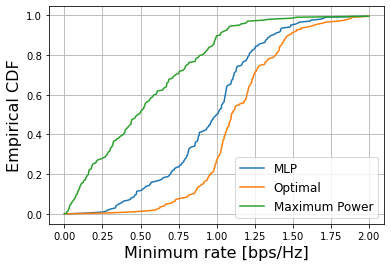

In [31]:
plt.plot(mlp_rates, y_axis, label = 'MLP')
plt.plot(opt_rates, y_axis, label = 'Optimal')
plt.plot(all_one_rates, y_axis, label = 'Maximum Power')
plt.xlabel('Minimum rate [bps/Hz]', {'fontsize':16})
plt.ylabel('Empirical CDF', {'fontsize':16})
plt.legend(fontsize = 12)
plt.grid()

## Reference
[1]  H. Q. Ngo, A. Ashikhmin, H. Yang, E. G. Larsson, and T. L. Marzetta, “Cell-free massive MIMO versus small cells,” IEEE Trans. Wireless Commun., vol. 16, no. 3, pp. 1834–1850, 2017.